# Autoencoder

Based on https://lilianweng.github.io/posts/2018-08-12-vae/

**Autocoder is invented to reconstruct high-dimensional data using a neural network model with a narrow bottleneck layer in the middle** (oops, this is probably not true for Variational Autoencoder, and we will investigate it in details in later sections). A nice byproduct is dimension reduction: the bottleneck layer captures a compressed latent encoding. Such a low-dimensional representation can be used as en embedding vector in various applications (i.e. search), help data compression, or reveal the underlying data generative factors.

**Autoencoder is a neural network designed to learn an identity function in an unsupervised way to reconstruct the original input while compressing the data in the process so as to discover a more efficient and compressed representation**. The idea was originated in the 1980s, and later promoted by the seminal paper by Hinton & Salakhutdinov, 2006.

It consists of two networks:

- **Encoder network**: It translates the original high-dimension input into the latent low-dimensional code. The input size is larger than the output size.
- **Decoder network**: The decoder network recovers the data from the code, likely with larger and larger output layers.

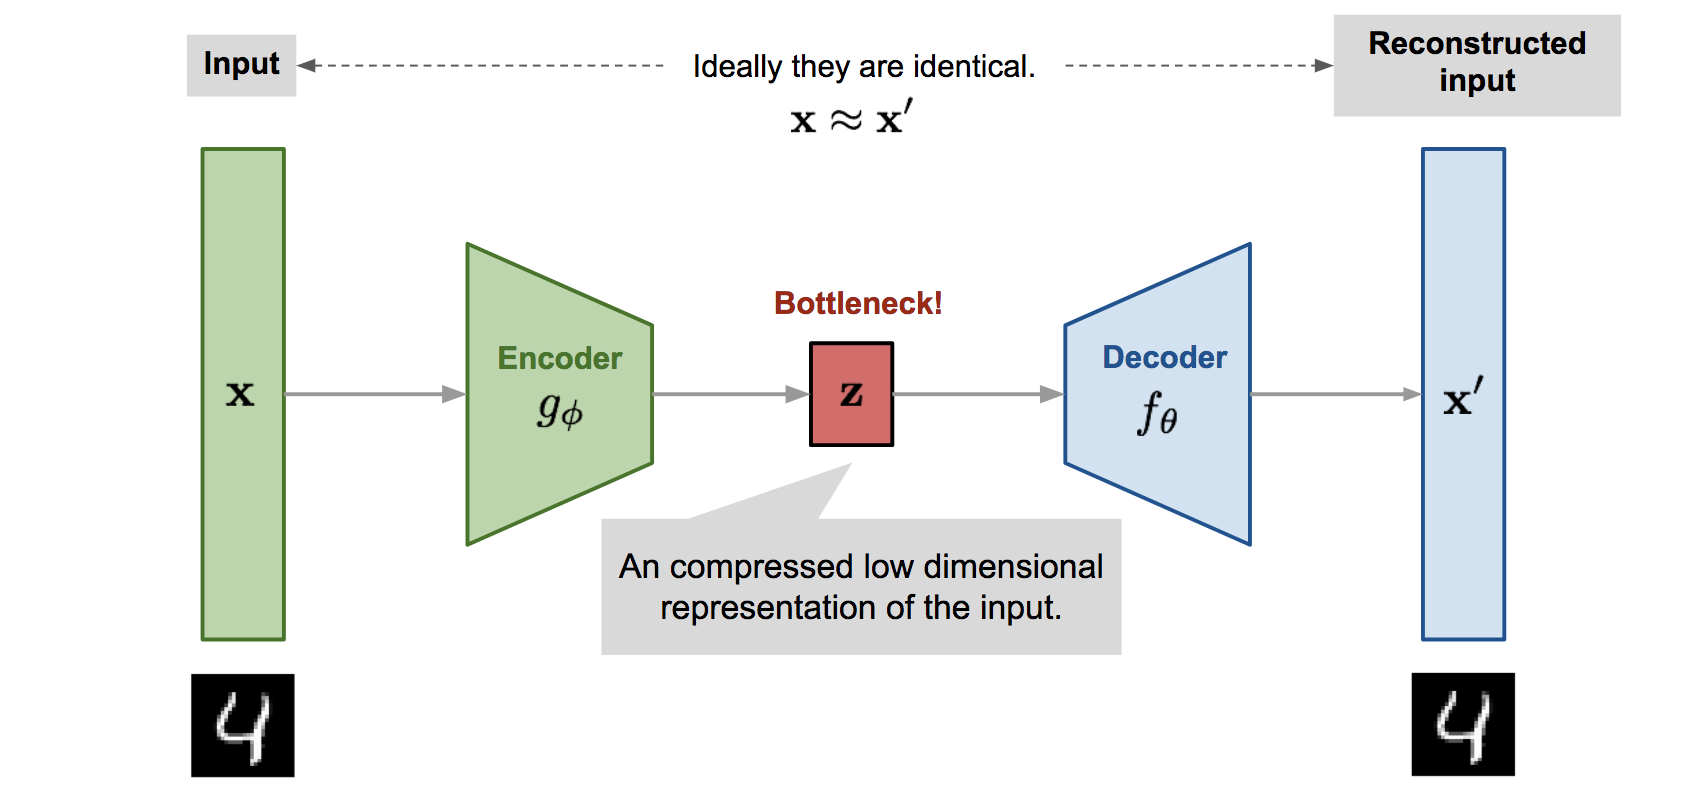

**The encoder network essentially accomplishes the dimensionality reduction, just like how we would use Principal Component Analysis (PCA) or Matrix Factorization (MF)**. In addition, the autoencoder is explicitly optimized for the data reconstruction from the code. A good intermediate representation not only can capture latent variables, but also benefits a full decompression process.

The model contains an encoder function $g(.)$ parameterized by $\phi$ and a decoder function $f(.)$ parameterized by $\theta$. The low-dimensional code learned for input $x$ in the bottleneck layer is $\mathbf{z} = g_\phi(\mathbf{x})$ and the reconstructed input is $\mathbf{x}’ = f_\theta(g_\phi(\mathbf{x}))$

The parameters $(\theta, \phi)$ are learned together to output a reconstructed data sample same as the original input, $\mathbf{x} \approx f_\theta(g_\phi(\mathbf{x}))$, or in other words, to learn an identity function. There are various metrics to quantify the difference between two vectors, such as cross entropy when the activation function is sigmoid, or as simple as MSE loss:

$$L_\text{AE}(\theta, \phi) = \frac{1}{n}\sum_{i=1}^n (\mathbf{x}^{(i)} - f_\theta(g_\phi(\mathbf{x}^{(i)})))^2$$



## Denoising Autoencoder

Since the autoencoder learns the identity function, we are facing the risk of “overfitting” when there are more network parameters than the number of data points.

To avoid overfitting and improve the robustness, Denoising Autoencoder (Vincent et al. 2008) proposed a modification to the basic autoencoder. The input is partially corrupted by adding noises to or masking some values of the input vector in a stochastic manner, $\tilde{\mathbf{x}} \sim \mathcal{M}_\mathcal{D}(\tilde{\mathbf{x}} \vert \mathbf{x})$. Then the model is trained to recover the original input (note: not the corrupt one).

$$\begin{aligned}
\tilde{\mathbf{x}}^{(i)} &\sim \mathcal{M}_\mathcal{D}(\tilde{\mathbf{x}}^{(i)} \vert \mathbf{x}^{(i)})\\
L_\text{DAE}(\theta, \phi) &= \frac{1}{n} \sum_{i=1}^n (\mathbf{x}^{(i)} - f_\theta(g_\phi(\tilde{\mathbf{x}}^{(i)})))^2
\end{aligned}$$

where $\mathcal{M}_\mathcal{D}$ defines the mapping from the true data samples to the noisy or corrupted ones.

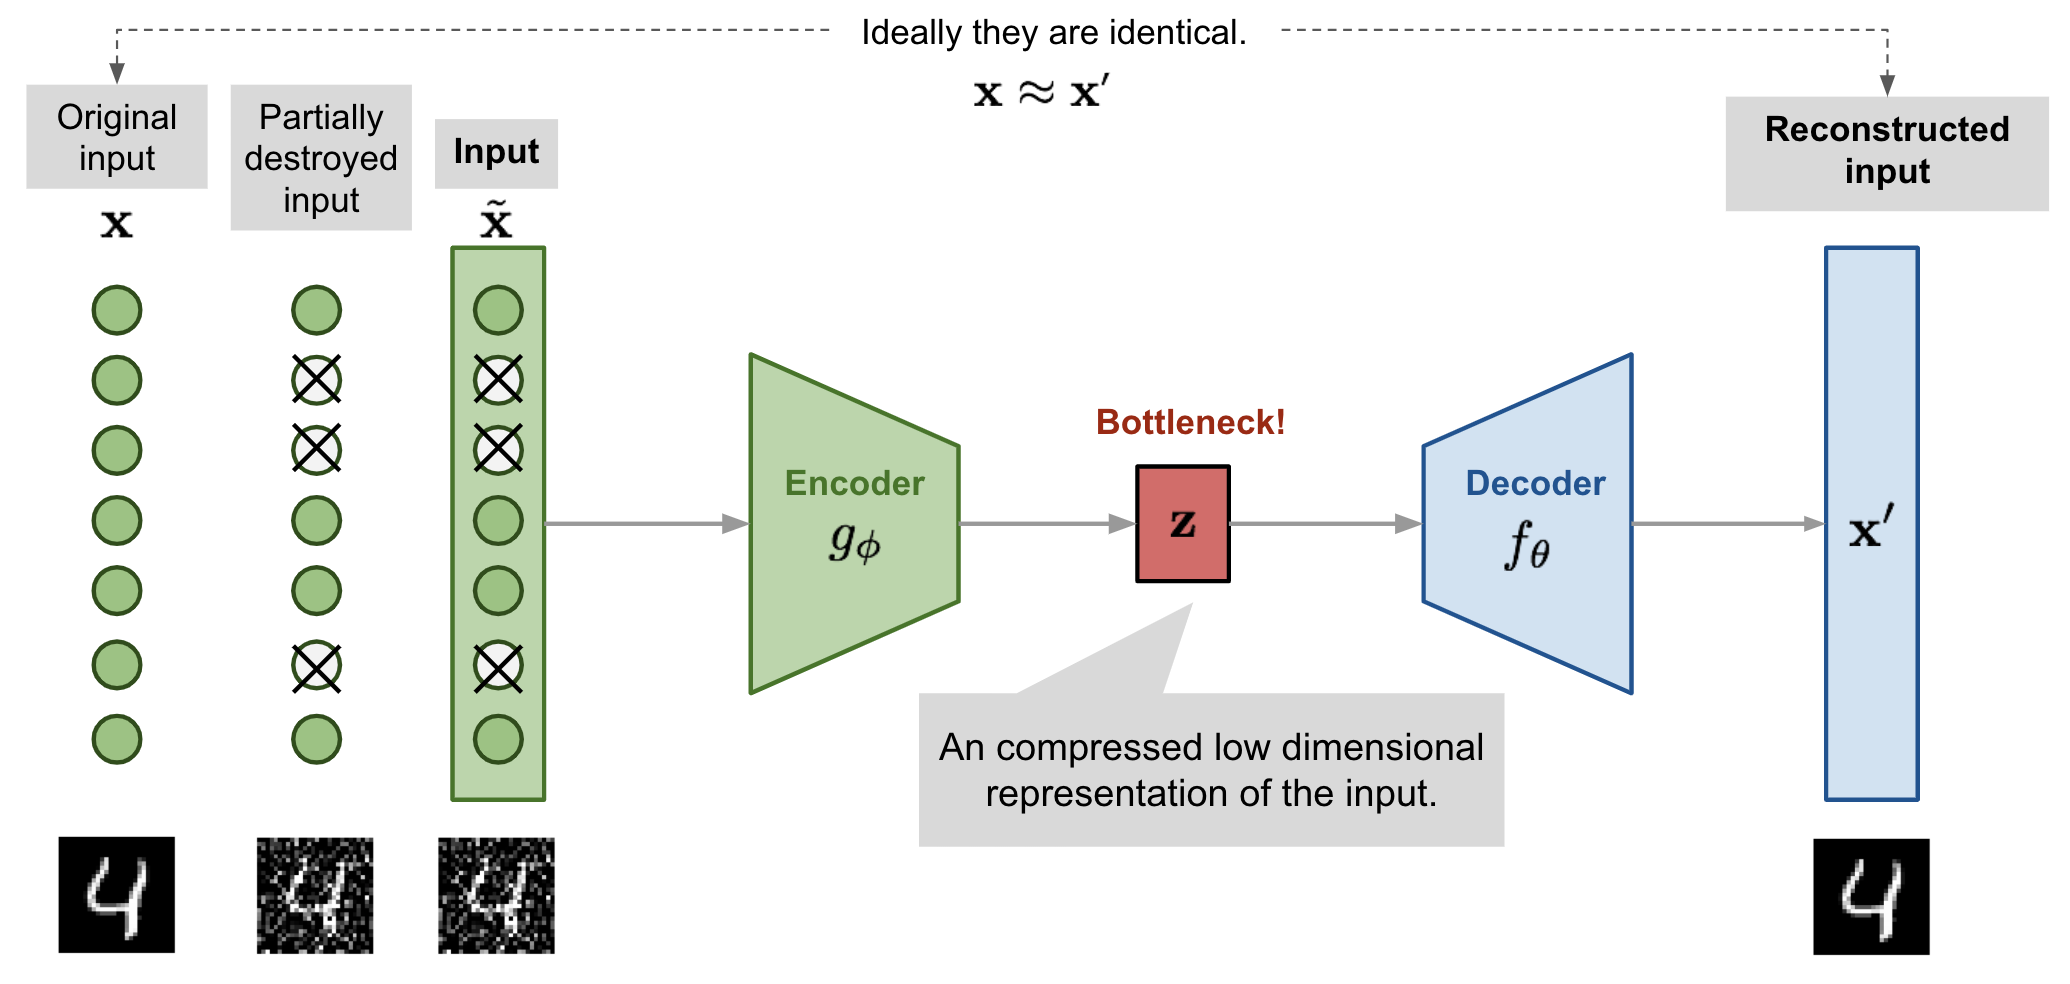


This design is motivated by the fact that humans can easily recognize an object or a scene even the view is partially occluded or corrupted. To “repair” the partially destroyed input, the denoising autoencoder has to discover and capture relationship between dimensions of input in order to infer missing pieces.

For high dimensional input with high redundancy, like images, the model is likely to depend on evidence gathered from a combination of many input dimensions to recover the denoised version rather than to overfit one dimension. This builds up a good foundation for learning robust latent representation.

The noise is controlled by a stochastic mapping $$\mathcal{M}_\mathcal{D}(\tilde{\mathbf{x}} \vert \mathbf{x})$$, and it is not specific to a particular type of corruption process (i.e. masking noise, Gaussian noise, salt-and-pepper noise, etc.). Naturally the corruption process can be equipped with prior knowledge

In the experiment of the original DAE paper, the noise is applied in this way: a fixed proportion of input dimensions are selected at random and their values are forced to 0. Sounds a lot like dropout, right? Well, the denoising autoencoder was proposed in 2008, 4 years before the dropout paper (Hinton, et al. 2012) ;)


In [1]:
import tensorflow as tf
import keras

2024-03-13 01:32:17.193883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 01:32:18.164747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def show_image(image):
    #im = plt.imshow(image, cmap='viridis')
    plt.figure(figsize=(8,2.5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def show_grid_images_labels_title(images, labels, columns, rows, title, start_index=0):
    fig = plt.figure(figsize=(10,2.5))
    
    
    for i in range(1, columns*rows + 1):
        img = images[i + start_index]
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(f'{labels[i + start_index]}')
        plt.axis('off')
        plt.imshow(img)
    
    fig.suptitle(f'{title}')
    plt.show()    

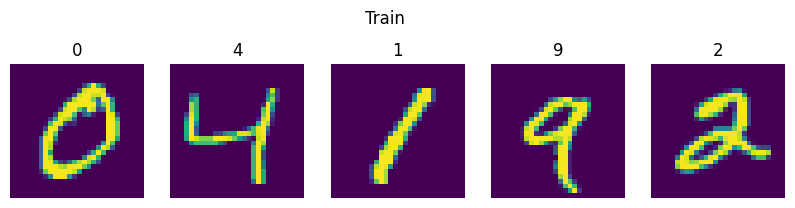

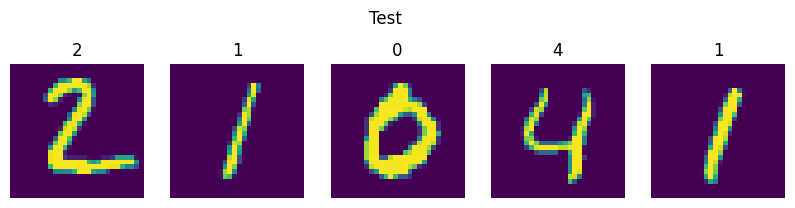

In [5]:
show_grid_images_labels_title(x_train, y_train, columns=5, rows=1, title='Train')

show_grid_images_labels_title(x_test, y_test, columns=5, rows=1, title='Test')

In [6]:
import numpy as np

np.random.seed(42)

def add_gaussian_noise(image, mean=0, std=1):
    """
    Add Gaussian noise to a binary image.

    Parameters:
    - image: Binary image of shape (28, 28).
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.
    
    Returns:
    - Noisy image.
    """
    gaussian_noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + gaussian_noise
    return noisy_image


def add_gaussian_noise_images(images, mean=0, std=1):
    noisy_images = [add_gaussian_noise(images[i], mean=mean, std=std) for i in range(len(images))]
    return np.array(noisy_images)

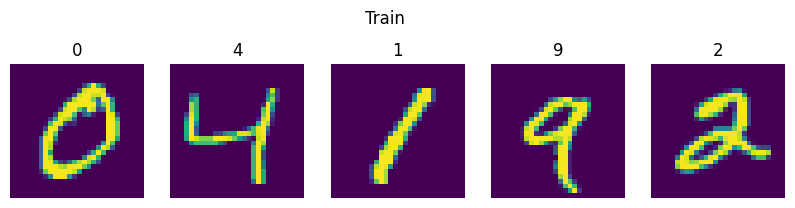

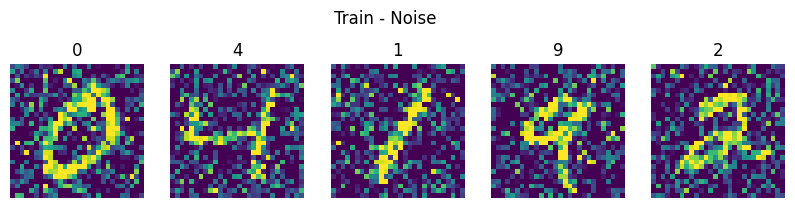

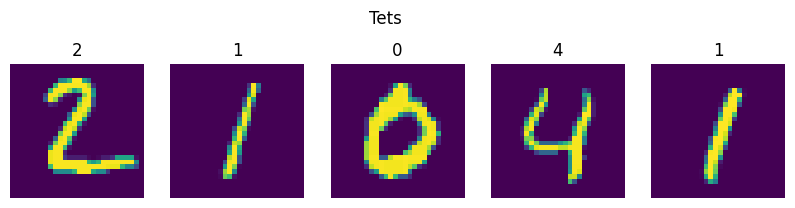

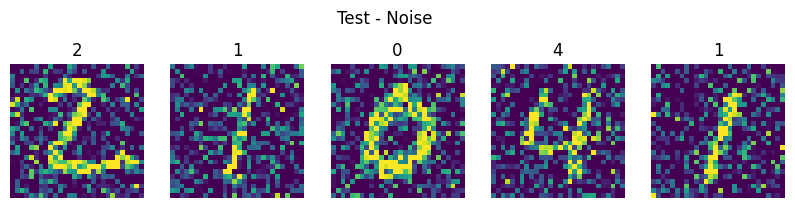

In [7]:
# Generar las imagenes ruidosas
x_train_noisy = add_gaussian_noise_images(x_train, mean=0, std=0.4)
x_test_noisy = add_gaussian_noise_images(x_test, mean=0, std=0.4)

# Clipear las imagenes ruidosas
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

# Mostrar las imagenes Train y Train - Noise
show_grid_images_labels_title(x_train, y_train, columns=5, rows=1, title='Train')
show_grid_images_labels_title(x_train_noisy, y_train, columns=5, rows=1, title='Train - Noise')

# Mostrar las imagenes Test y Test - Noise
show_grid_images_labels_title(x_test, y_test, columns=5, rows=1, title='Tets')
show_grid_images_labels_title(x_test_noisy, y_test, columns=5, rows=1, title='Test - Noise')

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

latent_dim = 64 

class Autoencoder(Model):
    
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim 
        
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

2024-03-13 01:32:23.651394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 01:32:23.718023: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError())

In [10]:
autoencoder.fit(
    x_train_noisy,  # Imágenes ruidosas como entrada
    x_train,        # Imágenes limpias como objetivos
    epochs=100,     # Número de épocas
    batch_size=128, # Tamaño del batch
    shuffle=True,   # Mezclar los datos en cada época
    validation_data=(x_test_noisy, x_test)  # También puedes proporcionar datos de prueba para evaluar.
)

Epoch 1/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0489 - val_loss: 0.0297
Epoch 2/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0247 - val_loss: 0.0204
Epoch 3/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0189 - val_loss: 0.0170
Epoch 4/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 5/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0148 - val_loss: 0.0142
Epoch 6/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 7/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 8/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 9/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 10/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0127 - val_lo

469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 82/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 83/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 84/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 85/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 86/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 87/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 88/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 89/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 90/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 

In [11]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________


In [12]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 784)               50960     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________


In [13]:
predict_test = autoencoder.predict([x_test_noisy])

313/313 [==============================] - 0s 1ms/step


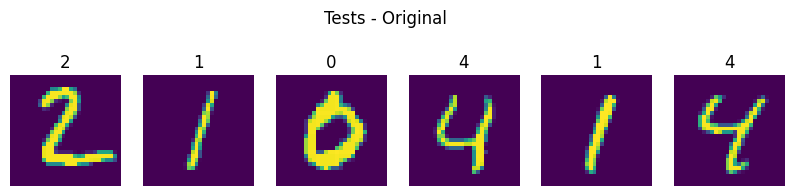

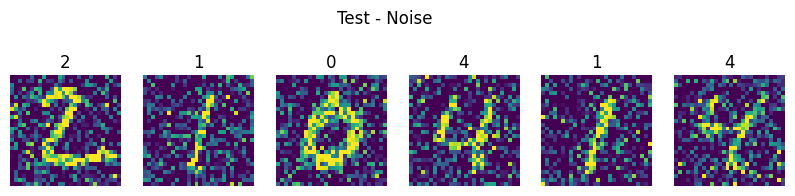

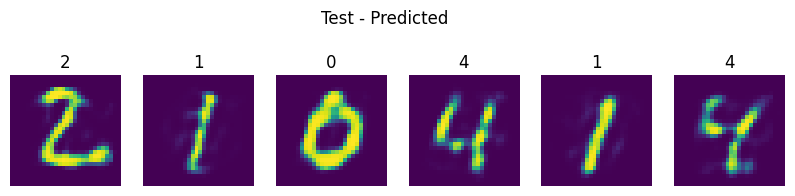

In [14]:
show_grid_images_labels_title(x_test, y_test, columns=6, rows=1, title='Tests - Original')
show_grid_images_labels_title(x_test_noisy, y_test, columns=6, rows=1, title='Test - Noise')
show_grid_images_labels_title(predict_test, y_test, columns=6, rows=1, title='Test - Predicted')

## Sparse Autoencoder

Sparse Autoencoder applies a “sparse” constraint on the hidden unit activation to avoid overfitting and improve robustness. It forces the model to only have a small number of hidden units being activated at the same time, or in other words, one hidden neuron should be inactivate most of time.

Recall that common activation functions include sigmoid, tanh, relu, leaky relu, etc. A neuron is activated when the value is close to 1 and inactivate with a value close to 0.

Let’s say there are $s_l$ neurons in the $l$-th hidden layer and the activation function for the $j$-th neuron in this layer is labelled as $a^{(l)}_j(.)$, $j=1, \dots, s_l$. The fraction of activation of this neuron $\hat{\rho}_j$ is expected to be a small number $\rho$, known as sparsity parameter; a common config is $\rho = 0.05$.

$$\hat{\rho}_j^{(l)} = \frac{1}{n} \sum_{i=1}^n [a_j^{(l)}(\mathbf{x}^{(i)})] \approx \rho$$

This constraint is achieved by adding a penalty term into the loss function. The KL-divergence $D_\text{KL}$ measures the difference between two Bernoulli distributions, one with mean $\rho$ and the other with mean $\hat{\rho}_j^{(l)}$. The hyperparameter $\beta$ controls how strong the penalty we want to apply on the sparsity loss.

$$\begin{aligned}
L_\text{SAE}(\theta) 
&= L(\theta) + \beta \sum_{l=1}^L \sum_{j=1}^{s_l} D_\text{KL}(\rho \| \hat{\rho}_j^{(l)}) \\
&= L(\theta) + \beta \sum_{l=1}^L \sum_{j=1}^{s_l} \rho\log\frac{\rho}{\hat{\rho}_j^{(l)}} + (1-\rho)\log\frac{1-\rho}{1-\hat{\rho}_j^{(l)}}
\end{aligned}$$



Las fórmulas proporcionadas describen cómo se implementa el concepto de dispersión (sparsity) en un autoencoder disperso (Sparse Autoencoder, SAE) para regular la activación de las neuronas en las capas ocultas, con el fin de prevenir el sobreajuste y mejorar la robustez del modelo. Vamos a desglosar y explicar cada parte de estas ecuaciones:

$\hat{\rho}_j^{(l)}$: Tasa promedio de activación de una neurona

Esta fórmula calcula el promedio de activación (o tasa de activación) de la $j$-ésima neurona en la capa oculta $l$-ésima, $\hat{\rho}_j^{(l)}$. Se obtiene promediando las activaciones de la neurona $j$-ésima sobre $n$ ejemplos de entrenamiento, donde $a_j^{(l)}(\mathbf{x}^{(i)})$ representa la activación de la neurona $j$-ésima para el $i$-ésimo ejemplo de entrada $\mathbf{x}^{(i)}$. La idea es que esta tasa de activación sea cercana a un pequeño valor $\rho$ (por ejemplo, $\rho=0.05$), lo que indica que cada neurona debería estar inactiva (cercana a 0) la mayoría del tiempo, y solo activarse (cercana a 1) para una pequeña fracción de los ejemplos de entrenamiento.
Restricción de dispersión mediante la divergencia de Kullback-Leibler (KL)

La divergencia de KL, $D_\text{KL}(\rho | \hat{\rho}_j^{(l)})$, mide la diferencia entre dos distribuciones de Bernoulli: una con media $\rho$ (el parámetro de dispersión deseado) y otra con media $\hat{\rho}_j^{(l)}$ (la tasa de activación promedio observada para la neurona $j$). La fórmula $\rho\log\frac{\rho}{\hat{\rho}_j^{(l)}} + (1-\rho)\log\frac{1-\rho}{1-\hat{\rho}_j^{(l)}}$ representa esta divergencia, cuantificando cuánto se desvía la activación real de la neurona de la activación deseada $\rho$. El objetivo es minimizar esta divergencia para cada neurona, forzando así que las activaciones se acerquen al valor deseado de dispersión $\rho$.
Función de pérdida del autoencoder disperso $L_\text{SAE}(\theta)$

La función de pérdida total del autoencoder disperso, $L_\text{SAE}(\theta)$, se compone de dos términos:
$L(\theta)$: La pérdida de reconstrucción, que mide qué tan bien el autoencoder puede reconstruir los datos de entrada después de comprimirlos en una representación más compacta. Esta parte asegura que, a pesar de la dispersión, el modelo aún aprende a capturar la estructura esencial de los datos de entrada.
El segundo término es la suma ponderada de las divergencias de KL para todas las neuronas en todas las capas ocultas, multiplicada por un hiperparámetro $\beta$. Este término impone la restricción de dispersión, penalizando las desviaciones de la tasa de activación promedio $\hat{\rho}_j^{(l)}$ del valor deseado $\rho$. El hiperparámetro $\beta$ controla la importancia de la restricción de dispersión en la función de pérdida total: un valor más alto de $\beta$ hace que el modelo priorice más fuertemente el cumplimiento de la restricción de dispersión.
En resumen, estas fórmulas describen cómo un autoencoder disperso implementa y aplica la restricción de dispersión para asegurar que solo un pequeño número de neuronas en las capas ocultas se active para cualquier ejemplo dado, lo que ayuda a mejorar la generalización y robustez del modelo al evitar que se sobreajuste a los datos de entrenamiento.

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses



class SparseAutoencoder(Model):
    
    def __init__(self, latent_dim):
        super(SparseAutoencoder, self).__init__()
        self.latent_dim = latent_dim 

        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def sparsity_loss(self, encoded):
        # Calcula la activación promedio por cada neurona en la capa oculta
        rho_hat = tf.reduce_mean(encoded, axis=0)
        # Usa la divergencia KL para calcular la pérdida de sparsity
        kl_divergence = self.rho * tf.math.log(self.rho / (rho_hat + 1e-10)) + (1 - self.rho) * tf.math.log((1 - self.rho) / (1 - rho_hat + 1e-10))
        sparsity_loss = self.beta * tf.reduce_sum(kl_divergence)
        return sparsity_loss

In [16]:
from tensorflow.keras.losses import Loss

class SparsityLoss(Loss):
    
    def __init__(self, rho=0.05, beta=0.1):
        super(SparsityLoss, self).__init__()
        self.rho = rho  # Sparsity parameter
        self.beta = beta  # Weight of the sparsity penalty term

    def call(self, x_true, x_pred):
        
        # Calcula la activación promedio por cada neurona en la capa oculta
        rho_hat = tf.reduce_mean(x_pred, axis=0)
        
        # Usa la divergencia KL para calcular la pérdida de sparsity
        kl_divergence = self.rho * tf.math.log(self.rho / (rho_hat + 1e-10)) + (1 - self.rho) * tf.math.log((1 - self.rho) / (1 - rho_hat + 1e-10))
        sparsity_loss = self.beta * tf.reduce_sum(kl_divergence)
        
        return sparsity_loss
    
    
class CombinedSparsityMSELoss(keras.losses.Loss):
    def __init__(self, rho=0.01, beta=0.2, lamb=0.2, name="combined_loss"):
        super().__init__(name=name)
        self.rho = rho
        self.beta = beta
        self.lamb = lamb
        self.mse = keras.losses.MeanSquaredError()
        self.sparsity_loss = SparsityLoss(rho=self.rho, beta=self.beta)

    def call(self, y_true, y_pred):
        mse_loss = self.mse(y_true, y_pred)
        # Asumiendo que y_pred ya son las activaciones del encoder para la pérdida de sparsity
        # Esto podría requerir adaptaciones dependiendo de cómo esté configurado tu modelo
        sparsity_loss_value = self.sparsity_loss(y_true, y_pred)
        return mse_loss + self.lamb * sparsity_loss_value

In [17]:
sparse_autoencoder = SparseAutoencoder(latent_dim=64)

In [18]:
sparse_autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=CombinedSparsityMSELoss(rho=0.01, beta=0.2, lamb=0.2))

In [19]:
sparse_autoencoder.fit(
    x_train,  # Imágenes ruidosas como entrada
    x_train,        # Imágenes limpias como objetivos
    epochs=100,     # Número de épocas
    batch_size=128, # Tamaño del batch
    shuffle=True,   # Mezclar los datos en cada época
    validation_data=(x_test, x_test)  # También puedes proporcionar datos de prueba para evaluar.
)

Epoch 1/100
469/469 [==============================] - 3s 5ms/step - loss: 0.7254 - val_loss: 0.1576
Epoch 2/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1147 - val_loss: 0.1563
Epoch 3/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1136 - val_loss: 0.1575
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1136 - val_loss: 0.1565
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1134 - val_loss: 0.1527
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1132 - val_loss: 0.1532
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1128 - val_loss: 0.1545
Epoch 8/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1128 - val_loss: 0.1526
Epoch 9/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1128 - val_loss: 0.1478
Epoch 10/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1127 - val_lo

469/469 [==============================] - 2s 4ms/step - loss: 0.1077 - val_loss: 0.1161
Epoch 82/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1076 - val_loss: 0.1154
Epoch 83/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1077 - val_loss: 0.1155
Epoch 84/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1076 - val_loss: 0.1161
Epoch 85/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1076 - val_loss: 0.1155
Epoch 86/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1076 - val_loss: 0.1159
Epoch 87/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1075 - val_loss: 0.1154
Epoch 88/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1075 - val_loss: 0.1161
Epoch 89/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1075 - val_loss: 0.1158
Epoch 90/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1076 - val_loss: 

In [20]:
encoder_activations = sparse_autoencoder.encoder(x_test).numpy()

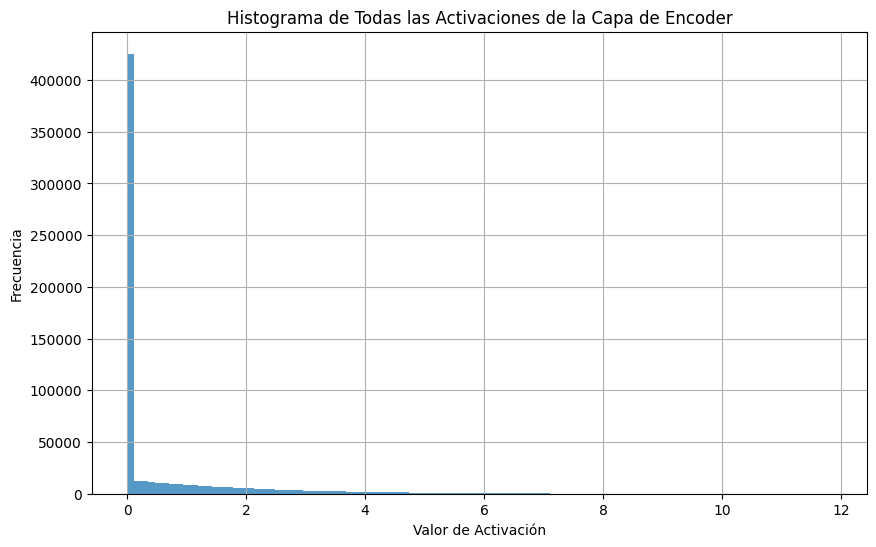

In [21]:
import matplotlib.pyplot as plt

def plot_activation_histograms(activations):
    """
    Dibuja un histograma de las activaciones de las neuronas en la capa de encoder.
    
    Args:
    - activations (numpy.ndarray): Las activaciones de la capa de encoder.
    """
    # Histograma de todas las activaciones
    plt.figure(figsize=(10, 6))
    activations_flat = activations.flatten()
    plt.hist(activations_flat, bins=100, alpha=0.75)
    plt.title('Histograma de Todas las Activaciones de la Capa de Encoder')
    plt.xlabel('Valor de Activación')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

# Ejemplo de uso
plot_activation_histograms(encoder_activations)

Entrenando con rho=0.01, beta=0.1...
Entrenando con rho=0.05, beta=0.1...
Entrenando con rho=0.1, beta=0.1...


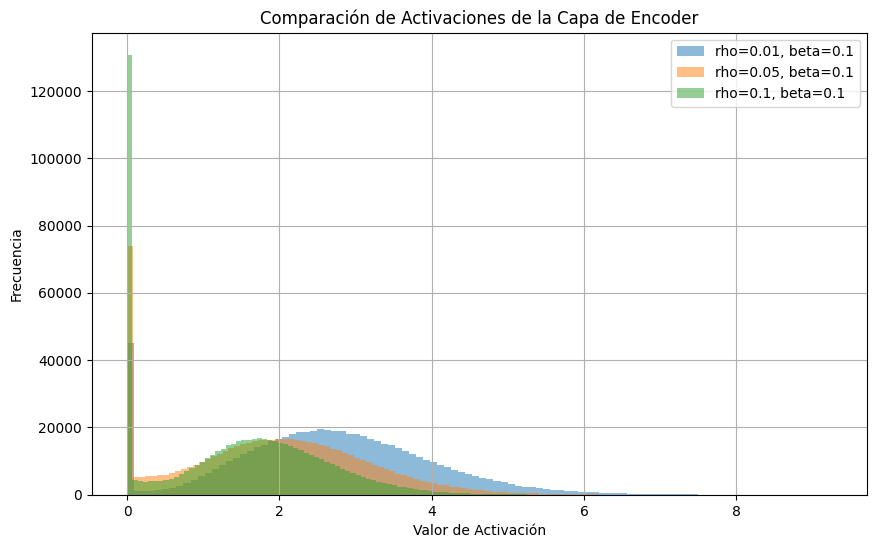

Entrenando con rho=0.01, beta=0.05...
Entrenando con rho=0.01, beta=0.1...
Entrenando con rho=0.01, beta=0.2...


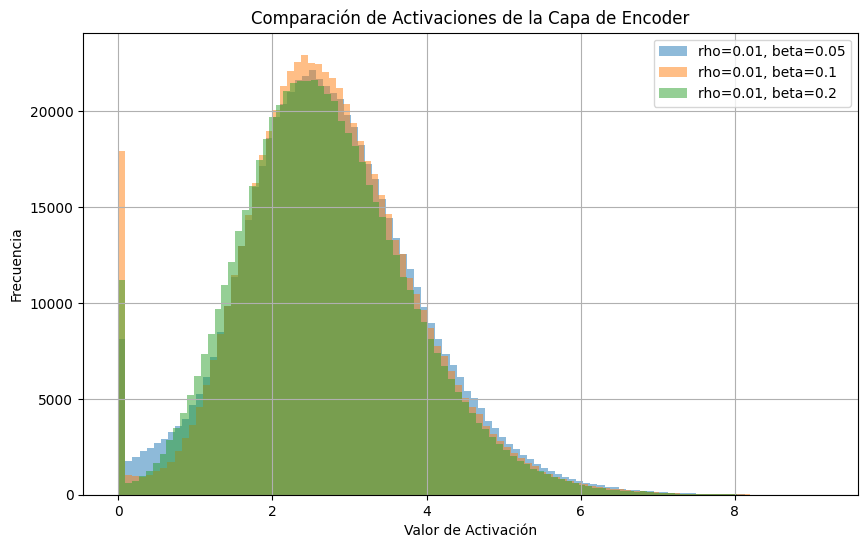

In [22]:
def compare_sparsity_effects(autoencoder, x_train, x_test, rho_beta_pairs):
    """
    Entrena y visualiza las activaciones de la capa de encoder para diferentes valores de rho y beta,
    todo en la misma gráfica con distintos colores.

    Args:
    - autoencoder (Model): La instancia base de tu SparseAutoencoder.
    - x_train (numpy.ndarray): Datos de entrenamiento.
    - x_test (numpy.ndarray): Datos de prueba para generar activaciones.
    - rho_beta_pairs (list of tuples): Lista de tuplas (rho, beta) para probar.
    """
    plt.figure(figsize=(10, 6))
    for rho, beta in rho_beta_pairs:
        print(f"Entrenando con rho={rho}, beta={beta}...")
        # Configura la pérdida con los valores actuales de rho y beta
        loss = SparsityLoss(rho=rho, beta=beta)
        
        # Clona el modelo para reiniciar el entrenamiento
        model_clone = keras.models.clone_model(autoencoder)
        model_clone.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=loss)
        
        # Entrenar el modelo. Asegúrate de usar callbacks o un número reducido de epochs para evitar largos tiempos de espera.
        model_clone.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, verbose=0)  # Reducir epochs para demostración
        
        # Obtener activaciones de la capa de encoder
        encoder_activations = model_clone.encoder(x_test).numpy().flatten()
        
        # Dibujar histograma de las activaciones
        plt.hist(encoder_activations, bins=100, alpha=0.5, label=f"rho={rho}, beta={beta}")

    plt.title('Comparación de Activaciones de la Capa de Encoder')
    plt.xlabel('Valor de Activación')
    plt.ylabel('Frecuencia')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Ejemplo de uso
# Asume que sparse_autoencoder es tu modelo, x_train tus datos de entrenamiento y x_test tus datos de prueba
rho_beta_pairs = [(0.01, 0.1), (0.05, 0.1), (0.1, 0.1)]  # Ejemplos de pares de rho y beta para probar
compare_sparsity_effects(sparse_autoencoder, x_train, x_test, rho_beta_pairs)

rho_beta_pairs = [(0.01, 0.05), (0.01, 0.1), (0.01, 0.2)]
compare_sparsity_effects(sparse_autoencoder, x_train, x_test, rho_beta_pairs)


In [23]:
predict_test = sparse_autoencoder.predict([x_test])

313/313 [==============================] - 0s 1ms/step


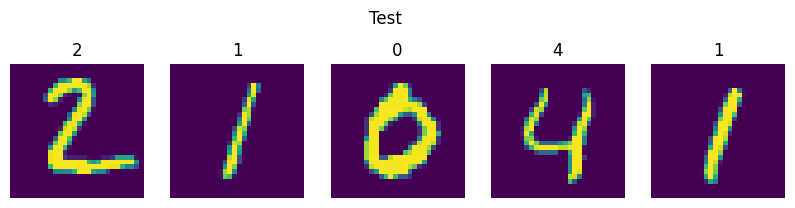

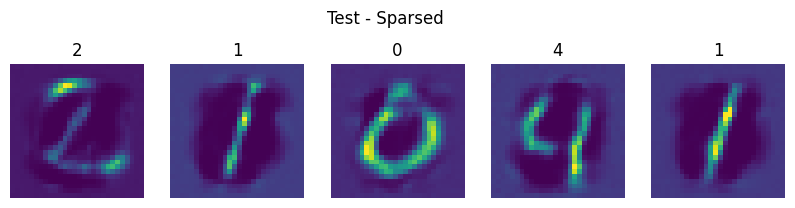

In [24]:
show_grid_images_labels_title(x_test, y_test, columns=5, rows=1, title='Test')
show_grid_images_labels_title(predict_test, y_test, columns=5, rows=1, title='Test - Sparsed')